In [1]:
import dash
import plotly.express as px
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import numpy as np
import pandas as pd

In [2]:
def calcular_tamaño_interno_iteraciones(tamaño, maxima_potencia=13):
    if maxima_potencia < 3:
        maxima_potencia = 3

    borde_mas_largo = max(tamaño)

    for potencia in range(1, maxima_potencia + 1):
        d = (2**potencia) + 1
        if borde_mas_largo <= d:
            return (d, d), potencia

    #failsafe: no values in the dimensions array were allowed, so print a warning and return
    # the maximum size.
    d = 2**maxima_potencia + 1
    print(f"Tamaño solicitado muy grande, usted ingresó {d} unidades")
    return (d, d), maxima_potencia

In [3]:
def ejecutar_paso_diamante(array, paso, variabilidad):
    # calcular las esquinas del diamante
    medio_paso = int(np.floor(paso / 2))
    pasos_x = range(medio_paso, array.shape[0], paso)
    pasos_y = pasos_x[:]

    for i in pasos_x:
        for j in pasos_y:
            if array[i,j] == -1.0:
                array[i,j] = definir_desplazamiento_diamante(array, i, j, medio_paso, variabilidad)

In [4]:
def ejecutar_paso_cuadrado(array, paso, variabilidad):

    medio_paso = int(np.floor(paso / 2))

    pasos_verticales_x = range(medio_paso, array.shape[0], paso)
    pasos_verticales_y = range(0, array.shape[1], paso)

    pasos_horizontales_x = range(0, array.shape[0], paso)
    pasos_horizontales_y = range(medio_paso, array.shape[1], paso)

    for i in pasos_horizontales_x:
        for j in pasos_horizontales_y:
            array[i,j] = definir_desplazamiento_cuadrado(array, i, j, medio_paso, variabilidad)

    for i in pasos_verticales_x:
        for j in pasos_verticales_y:
            array[i,j] = definir_desplazamiento_cuadrado(array, i, j, medio_paso, variabilidad)

In [5]:
def definir_desplazamiento_diamante(array, i, j, medio_paso, variabilidad):

    # defines the midpoint displacement for the diamond step

    arriba_izq = array[i - medio_paso, j - medio_paso]
    arriba_der = array[i - medio_paso, j + medio_paso]
    abajo_izq = array[i + medio_paso, j - medio_paso]
    abajo_der = array[i + medio_paso, j + medio_paso]

    promedio = (arriba_izq + arriba_der + abajo_izq + abajo_der) / 4.0

    valor_aleatorio = np.random.uniform()

    return (variabilidad * valor_aleatorio) + (1.0 - variabilidad) * promedio

In [6]:
def definir_desplazamiento_cuadrado(array, i, j, medio_paso, variabilidad):
    #Defines the midpoint displacement for the square step
    
    acumulador = 0.0
    dividir_por = 4

    # checkear celda superior
    if i - medio_paso >= 0:
        acumulador += array[i - medio_paso, j]
    else:
        dividir_por -= 1

    # checkear celda inferior
    if i + medio_paso < array.shape[0]:
        acumulador += array[i + medio_paso, j]
    else:
        dividir_por -= 1

    # checkear celda a la izquierda
    if j - medio_paso >= 0:
        acumulador += array[i, j - medio_paso]
    else:
        dividir_por -= 1

    # checkear celda a la derecha
    if j + medio_paso < array.shape[0]:
        acumulador += array[i, j + medio_paso]
    else:
        dividir_por -= 1

    promedio = acumulador / dividir_por

    valor_aleatorio = np.random.uniform()

    return (variabilidad * valor_aleatorio) + (1.0 - variabilidad) * promedio

In [7]:
def generar_terreno(tamaño = (1, 1),
                   altura_min = 0.5,
                   altura_max = 1,
                   variabilidad = 2,
                   semilla = None):

    # checkeo de parametros
    if variabilidad > 1:
        return 'Error! parametro de variabilidad excedido'
    if variabilidad < 0:
        return 'Error! parametro de variabilidad excedido'

    tamaño_interno, iteraciones = calcular_tamaño_interno_iteraciones(tamaño)
    
    # inicializar el arreglo de floats, los llenamos de "-1"
    array = np.full(tamaño_interno, -1, dtype='float')

    # establecemos la semilla para que al ejecutarlo varias veces nos dé el mismo resultado
    np.random.seed(semilla)

    # paso 1: inicializar las esquinas
    array[0, 0] = np.random.uniform()
    array[tamaño_interno[0] - 1, 0] = np.random.uniform()
    array[0, tamaño_interno[1] - 1] = np.random.uniform()
    array[tamaño_interno[0] - 1, tamaño_interno[1] - 1] = np.random.uniform()

    # repetir los pasos
    for i in range(iteraciones):
        r = np.power(variabilidad, i)

        paso = int(np.floor((tamaño_interno[0] - 1) / np.power(2, i)))

        ejecutar_paso_diamante(array, paso, r)
        ejecutar_paso_cuadrado(array, paso, r)

    # reescalar los valores para satisfacer los limites de altura que se pasaron por parámetro
    array = altura_min + (array * (altura_max - altura_min))

    # recortar el arreglo para satisfacer el tamaño que se pasó por parámetro
    return array[:tamaño[0], :tamaño[1]]

In [8]:
app = JupyterDash(__name__,
external_stylesheets=[dbc.themes.BOOTSTRAP])

# Build App
app.layout = html.Div([
    dbc.Row(
        dbc.Col(
                html.H1("Terrenos Interactivos")
           )
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Altura Mínima del Terreno"),
            dcc.Slider(
                id='slider_altura_min',
                min=0,
                max=5,
                value=3,
                marks={i: f'{i}' for i in range(0,6)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Altura Máxima del Terreno"),
            dcc.Slider(
                id='slider_altura_max',
                min=5,
                max=10,
                value=7,
                marks={i: f'{i}' for i in range(5,11)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Variabilidad del Terreno"),
            dcc.Slider(
                id='slider_variabilidad',
                min=0,
                max=100,
                value=50,
                marks={i: f'{i/100}' for i in range(0,101,10)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Longitud del Lado 1"),
            dcc.Slider(
                id='slider_tamaño_x',
                min=1,
                max=25,
                value=5,
                marks={i: f'{i}' for i in range(1, 26, 2)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Longitud del Lado 2"),
            dcc.Slider(
                id='slider_tamaño_y',
                min=1,
                max=25,
                value=5,
                marks={i: f'{i}' for i in range(1, 26, 2)}
            )
        ])
    ),    
    dbc.Row(
        dbc.Col([
            html.H3("La magia:"),
            dcc.Graph(id='graph')
        ])
    )]
)
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input('slider_altura_min', 'value'),
     Input('slider_altura_max', 'value'),
     Input('slider_variabilidad', 'value'),
     Input('slider_tamaño_x', 'value'),
     Input('slider_tamaño_y', 'value')]
)

def update_figure(altura_min, altura_max, variabilidad, tamaño_x, tamaño_y):
    Z = generar_terreno(
            tamaño=(tamaño_x, tamaño_y),
            altura_min=altura_min,
            altura_max=altura_max,
            variabilidad=variabilidad/100,
            semilla=0
    )

    x = np.linspace(-tamaño_x/2, tamaño_x/2, tamaño_x)
    y = np.linspace(-tamaño_y/2, tamaño_y/2, tamaño_y)

    X,Y = np.meshgrid(x,y)
    
    fig = go.Figure(data=[go.Surface(z=Z, colorscale='Blues', reversescale=True)])
    return fig

# Run app and display result inline in the notebook
app.run_server(mode='jupyterlab', port=8088)

In [30]:
# Load Data

app = JupyterDash(__name__,
external_stylesheets=[dbc.themes.BOOTSTRAP])

# Build App
app.layout = html.Div([
    dbc.Row(
        dbc.Col(
                html.H1("Terrenos Interactivos")
           )
    ),
    
    dbc.Row(
        dbc.Col([
            html.H3("Año: "),
            dcc.Slider(
                id='slider_anio',
                min=1950,
                max=2090,
                value=2020,
                step=None,
                marks={i: f'{i}' for i in range(1950, 2091, 10)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Glaciar resultante: "),
            dcc.Graph(id='graph')
        ])
    )
]
)
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    Input('slider_anio', 'value')
)

def update_figure(anio):
    if (anio==1950):
        altura_min=9
        altura_max=10
        variabilidad=0.7
        temp="4.9°C"
    elif (anio==1960):
        altura_min=8.8696
        altura_max=9.8696
        variabilidad=0.6913
        temp="5°C"
    elif (anio==1970):
        altura_min=8.8044
        altura_max=9.8044
        variabilidad=0.6869
        temp="6.05°C"
    elif (anio==1980):
        altura_min=8.6088
        altura_max=9.6088
        variabilidad=0.6739
        temp="6.2°C"
    elif (anio==1990):
        altura_min=8.45232
        altura_max=9.45232
        variabilidad=0.6635
        temp="6.32°C"
    elif (anio==2000):
        altura_min=8.0872
        altura_max=9.0872
        variabilidad=0.6391
        temp="6.6°C"
    elif (anio==2010):
        altura_min=7.8916
        altura_max=8.8916
        variabilidad=0.6261
        temp="6.75°C"
    elif (anio==2020):
        altura_min=7.5656
        altura_max=8.5656
        variabilidad=0.6
        temp="7°C"
    elif (anio==2030):
        altura_min=6.9136
        altura_max=7.9136
        variabilidad=0.5609
        temp="7.5°C"
    elif (anio==2040):
        altura_min=6.2616
        altura_max=7.2616
        variabilidad=0.5175
        temp="8°C"
    elif (anio==2050):
        altura_min=4.9576
        altura_max=5.9576
        variabilidad=0.4306
        temp="9°C"
    elif (anio==2060):
        altura_min=3.6536
        altura_max=4.6536
        variabilidad=0.3437
        temp="10°C"
    elif (anio==2070):
        altura_min=3.0016
        altura_max=4.0016
        variabilidad=0.3
        temp="10.5°C"
    elif (anio==2080):
        altura_min=1.5672
        altura_max=2.5672
        variabilidad=0.2047
        temp="11.6°C"
    else:
        altura_min=0
        altura_max=1
        variabilidad=0.1
        temp="12.8°C"
    #para mostrar medidas de altura mas realistas (en metros)
    altura_min=altura_min*7 
    altura_max=altura_max*7
    longitud = 50
    tamaño_x=longitud
    tamaño_y=longitud
    Z = generar_terreno(tamaño=(tamaño_x, tamaño_y), altura_min=altura_min, altura_max=altura_max, variabilidad=variabilidad, semilla=0)

    superficies = [go.Surface(z=Z, colorscale='blues', reversescale=True)] 
    
    z_minimo = np.min(Z)
    z_maximo= np.max(Z)
    fila_de_ceros = np.full(longitud, 0)
    fila_z_minimo = np.full(longitud, z_minimo)
    fila_de_valor_limite = np.full(longitud, longitud-1)
    fila_lineal = np.linspace(0, longitud-1, longitud)
    
#   ---------- Pared 1:
    x = np.array([fila_de_ceros, fila_de_ceros])
    y = np.array([fila_lineal, fila_lineal])
    z = np.array([fila_z_minimo, Z[:,0]])
    
    superficies.append(go.Surface(x=x, y=y, z=z, colorscale=[[0,'rgb(192,229,232)'],[1,'rgb(66,146,198)']],cmin=z_minimo, cmax=z_maximo, reversescale=True))
#   ---------- Pared 2:
    x = np.array([fila_lineal, fila_lineal])
    y = np.array([fila_de_ceros, fila_de_ceros])
    z = np.array([fila_z_minimo, Z[0,:]])   

    superficies.append(go.Surface(x=x, y=y, z=z, colorscale=[[0,'rgb(192,229,232)'],[1,'rgb(66,146,198)']],cmin=z_minimo, cmax=z_maximo, reversescale=True))
#   ---------- Pared 3:
    x = np.array([fila_lineal, fila_lineal])
    y = np.array([fila_de_valor_limite, fila_de_valor_limite])
    z = np.array([fila_z_minimo, Z[longitud-1,:]])   

    superficies.append(go.Surface(x=x, y=y, z=z, colorscale=[[0,'rgb(192,229,232)'],[1,'rgb(66,146,198)']],cmin=z_minimo, cmax=z_maximo, reversescale=True))
#   ---------- Pared 4:
    x = np.array([fila_de_valor_limite, fila_de_valor_limite])
    y = np.array([fila_lineal, fila_lineal])
    z = np.array([fila_z_minimo, Z[:, longitud-1]]) 

    superficies.append(go.Surface(x=x, y=y, z=z, colorscale=[[0,'rgb(192,229,232)'],[1,'rgb(66,146,198)']],cmin=z_minimo, cmax=z_maximo, reversescale=True))
#   ----------- Piso:
    x, y = np.meshgrid(fila_lineal, fila_lineal)
    z = np.full((longitud, longitud), z_minimo)
    
    superficies.append(go.Surface(x = x, y = y, z = z, colorscale='blues'))
    
    fig = go.Figure(data=superficies)
    return fig 
# Run app and display result inline in the notebook
app.run_server(mode='jupyterlab', port=8080)

**versión con paredes**

In [9]:
app = JupyterDash(__name__,
external_stylesheets=[dbc.themes.BOOTSTRAP])

# Build App
app.layout = html.Div([
    dbc.Row(
        dbc.Col(
                html.H1("Terrenos Interactivos")
           )
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Altura Mínima del Terreno"),
            dcc.Slider(
                id='slider_altura_min',
                min=0,
                max=5,
                value=3,
                marks={i: f'{i}' for i in range(0,6)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Altura Máxima del Terreno"),
            dcc.Slider(
                id='slider_altura_max',
                min=5,
                max=10,
                value=7,
                marks={i: f'{i}' for i in range(5,11)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Variabilidad del Terreno"),
            dcc.Slider(
                id='slider_variabilidad',
                min=0,
                max=100,
                value=50,
                marks={i: f'{i/100}' for i in range(0,101,10)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Longitud "),
            dcc.Slider(
                id='slider_longitud',
                min=1,
                max=25,
                value=5,
                marks={i: f'{i}' for i in range(1, 26, 2)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            dcc.Graph(id='graph')
        ])
    )]
)
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input('slider_altura_min', 'value'),
     Input('slider_altura_max', 'value'),
     Input('slider_variabilidad', 'value'),
     Input('slider_longitud', 'value',
    Input('slider_longitud', 'value')]
)

def update_figure(altura_min, altura_max, variabilidad, longitud):
    Z = generar_terreno(
            tamaño=(longitud, longitud),
            altura_min=altura_min,
            altura_max=altura_max,
            variabilidad=variabilidad/100,
            semilla=0
    )
    
    superficies = [go.Surface(z=Z)] 
    fila_de_ceros = np.full(longitud, 0)
    fila_de_valor_limite = np.full(longitud, longitud-1)
    fila_lineal = np.linspace(0, longitud-1, longitud)
    max_r = np.linspace(9,9,10)
    lin_r = np.linspace(0,9,10)

#   ---------- Pared 1:
    x = np.array([fila_de_ceros, fila_de_ceros])
    y = np.array([fila_lineal, fila_lineal])
    z = np.array([fila_de_ceros, Z[:,0]])
    
    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 2:
    x = np.array([fila_lineal, fila_lineal])
    y = np.array([fila_de_ceros, fila_de_ceros])
    z = np.array([fila_de_ceros, Z[0,:]])   

    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 3:
    x = np.array([fila_lineal, fila_lineal])
    y = np.array([fila_de_valor_limite, fila_de_valor_limite])
    z = np.array([fila_de_ceros, Z[longitud-1,:]])   

    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 4:
    x = np.array([fila_de_valor_limite, fila_de_valor_limite])
    y = np.array([fila_lineal, fila_lineal])
    z = np.array([fila_de_ceros, Z[:, longitud-1]]) 

    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ----------- Piso:
    x, y = np.meshgrid(fila_lineal, fila_lineal)
    z = np.full((longitud, longitud), 0)
    superficies.append(go.Surface(x = x, y = y, z = z, opacity = 0.9))

    fig = go.Figure(data = superficies)
    return fig

# Run app and display result inline in the notebook
app.run_server(mode='jupyterlab', port=8088)

# versión con paredes moviels

In [120]:
app = JupyterDash(__name__,
external_stylesheets=[dbc.themes.BOOTSTRAP])

# Build App
app.layout = html.Div([
    dbc.Row(
        dbc.Col(
                html.H1("Terrenos Interactivos")
           )
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Altura Mínima del Terreno"),
            dcc.Slider(
                id='slider_altura_min',
                min=0,
                max=5,
                value=3,
                marks={i: f'{i}' for i in range(0,6)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Altura Máxima del Terreno"),
            dcc.Slider(
                id='slider_altura_max',
                min=5,
                max=10,
                value=7,
                marks={i: f'{i}' for i in range(5,11)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Variabilidad del Terreno"),
            dcc.Slider(
                id='slider_variabilidad',
                min=0,
                max=100,
                value=50,
                marks={i: f'{i/100}' for i in range(0,101,10)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Longitud "),
            dcc.Slider(
                id='slider_longitud',
                min=1,
                max=25,
                value=5,
                marks={i: f'{i}' for i in range(1, 26, 2)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            html.H3("Tiempo "),
            dcc.Slider(
                id='slider_iteracion',
                min=1,
                max=25,
                value=1,
                marks={i: f'{i}' for i in range(0, 26, 1)}
            )
        ])
    ),
    dbc.Row(
        dbc.Col([
            dcc.Graph(id='graph')
        ])
    )]
)
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input('slider_altura_min', 'value'),
     Input('slider_altura_max', 'value'),
     Input('slider_variabilidad', 'value'),
     Input('slider_longitud', 'value'),
     Input('slider_tiempo', 'value')]
)

def update_figure(altura_min, altura_max, variabilidad, longitud, iteracion):
    Z = generar_terreno(
            tamaño=(longitud, longitud),
            altura_min=altura_min,
            altura_max=altura_max,
            variabilidad=variabilidad/100,
            semilla=0
    )
    
    superficies = [go.Surface(z = Z[: , : - iteracion])] 
    fila_de_ceros = np.full(longitud, 0)
    fila_de_valor_limite = np.full(longitud, longitud-1)
    fila_lineal = np.linspace(0, longitud-1, longitud)
    max_r = np.linspace(9,9,10)
    lin_r = np.linspace(0,9,10)

#   ---------- Pared 1:
    x = np.array([fila_de_ceros, fila_de_ceros])
    y = np.array([fila_lineal, fila_lineal])
    z = np.array([fila_de_ceros, Z[:,0]])

    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 2:
    x = np.array([fila_lineal[:-iteracion], fila_lineal[:-iteracion]])
    y = np.array([fila_de_ceros[:-iteracion], fila_de_ceros[:-iteracion]])
    z = np.array([fila_de_ceros[:-iteracion], Z[0,:][:-iteracion]])  
    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 3:
    x = np.array([fila_lineal[:-iteracion], fila_lineal[:-iteracion]])
    y = np.array([fila_de_valor_limite[:-iteracion], fila_de_valor_limite[:-iteracion]])
    z = np.array([fila_de_ceros[:-iteracion], Z[longitud-1,:][:-iteracion]])   

    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 4:
    x = np.array([fila_de_valor_limite - iteracion, fila_de_valor_limite - iteracion])
    y = np.array([fila_lineal, fila_lineal])
    z = np.array([fila_de_ceros, Z[:, -iteracion-1]]) 

    superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Piso:    
    x, y = np.meshgrid(fila_lineal[:-iteracion], fila_lineal)
    z = np.full((longitud-iteracion+1, longitud), 0)
    
    superficies.append(go.Surface(x = x, y = y, z = z, opacity = 0.9))

    fig = go.Figure(data = superficies)
    fig.update_layout(
        scene = dict(xaxis = dict(nticks=4, range=[0,longitud])), 
        scene_camera = dict(
            eye=dict(x=2, y=2, z=0.1)
        )
    )
    return fig

# Run app and display result inline in the notebook
app.run_server(mode='jupyterlab', port=8088)

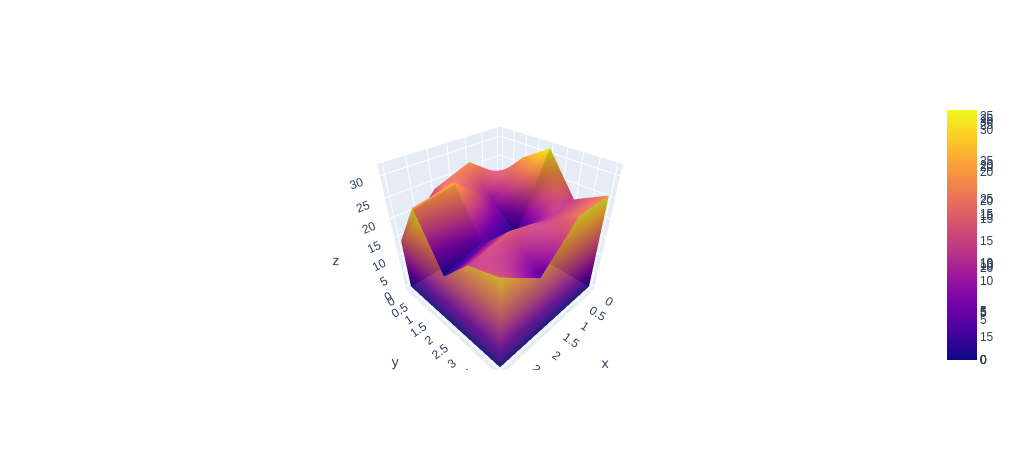

In [99]:
Z = generar_terreno(
        tamaño=(5, 5),
        altura_min=2,
        altura_max=35,
        variabilidad=50/100,
        semilla=0
)
longitud = 5
iteracion = 1
superficies = [go.Surface(z = Z[: , : - iteracion])] 
fila_de_ceros = np.full(longitud, 0)
fila_de_valor_limite = np.full(longitud, longitud-1)
fila_lineal = np.linspace(0, longitud-1, longitud)
max_r = np.linspace(9,9,10)
lin_r = np.linspace(0,9,10)

#   ---------- Pared 1:
x = np.array([fila_de_ceros, fila_de_ceros])
y = np.array([fila_lineal, fila_lineal])
z = np.array([fila_de_ceros, Z[:,0]])

superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 2:
x = np.array([fila_lineal[:-iteracion], fila_lineal[:-iteracion]])
y = np.array([fila_de_ceros[:-iteracion], fila_de_ceros[:-iteracion]])
z = np.array([fila_de_ceros[:-iteracion], Z[0,:][:-iteracion]])   
superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 3:
x = np.array([fila_lineal[:-iteracion], fila_lineal[:-iteracion]])
y = np.array([fila_de_valor_limite[:-iteracion], fila_de_valor_limite[:-iteracion]])
z = np.array([fila_de_ceros[:-iteracion], Z[longitud-1,:][:-iteracion]])   

superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 4:
x = np.array([fila_de_valor_limite - iteracion, fila_de_valor_limite - iteracion])
y = np.array([fila_lineal, fila_lineal])
z = np.array([fila_de_ceros, Z[:, -iteracion-1]]) 

superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))

fig = go.Figure(data = superficies)
fig.show()

In [114]:
Z = generar_terreno(
        tamaño=(5, 5),
        altura_min=2,
        altura_max=35,
        variabilidad=50/100,
        semilla=0
)
longitud = 5
iteracion = 0
superficies = [go.Surface(z = Z[: , : - iteracion])] 
fila_de_ceros = np.full(longitud, 0)
fila_de_valor_limite = np.full(longitud, longitud-1)
fila_lineal = np.linspace(0, longitud-1, longitud)
max_r = np.linspace(9,9,10)
lin_r = np.linspace(0,9,10)

#   ---------- Pared 1:
x = np.array([fila_de_ceros, fila_de_ceros])
y = np.array([fila_lineal, fila_lineal])
z = np.array([fila_de_ceros, Z[:,0]])

superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 2:
x = np.array([fila_lineal[:-(iteracion+1)], fila_lineal[:-(iteracion+1)]])
y = np.array([fila_de_ceros[:-(iteracion+1)], fila_de_ceros[:-(iteracion+1)]])
z = np.array([fila_de_ceros[:-(iteracion+1)], Z[0,:][:-(iteracion+1)]])   
superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 3:
x = np.array([fila_lineal[:-(iteracion+1)], fila_lineal[:-(iteracion+1)]])
y = np.array([fila_de_valor_limite[:-(iteracion+1)], fila_de_valor_limite[:-(iteracion+1)]])
z = np.array([fila_de_ceros[:-(iteracion+1)], Z[longitud-1,:][:-(iteracion+1)]])   

superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))
#   ---------- Pared 4:
x = np.array([fila_de_valor_limite - iteracion, fila_de_valor_limite - iteracion])
y = np.array([fila_lineal, fila_lineal])
z = np.array([fila_de_ceros, Z[:, longitud-iteracion-1]]) 

superficies.append(go.Surface(x=x, y=y, z=z, opacity = 0.9))

fig = go.Figure(data = superficies)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,longitud])            
    )
)
fig.show()

In [62]:
Z

array([[2.5488135 , 2.66893689, 2.64589411, 2.50839037, 2.60276338],
       [2.71788593, 2.56895169, 2.67744488, 2.69084927, 2.76364116],
       [2.891773  , 2.49216292, 2.4236548 , 2.51115629, 2.96366276],
       [2.6688119 , 2.59589361, 2.57563495, 2.58659041, 2.55915374],
       [2.71518937, 2.64282521, 2.43758721, 2.58425302, 2.54488318]])

In [71]:
x3

array([[0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [72]:
y3

array([[4, 4, 4, 4],
       [4, 4, 4, 4]])

In [73]:
z3

array([[0.        , 0.        , 0.        , 0.        ],
       [2.71518937, 2.64282521, 2.43758721, 2.58425302]])

In [ ]:
#   ----------- Piso:
    x, y = np.meshgrid(fila_lineal, fila_lineal)
    z = np.full((longitud, longitud), 0)
    superficies.append(go.Surface(x = x, y = y, z = z, opacity = 0.9))


In [224]:
zero_r = np.linspace(0,0,10)
max_r = np.linspace(9,9,10)
lin_r = np.linspace(0,9,10)

x1 = np.array([zero_r, zero_r])
y1 = np.array([lin_r,lin_r])
z1 = np.array([f11,f21])
s1 = go.Surface(x = x1, y = y1, z = z1, opacity = 0.5)

x2 = np.array((lin_r,lin_r))
y2 = np.array((zero_r, zero_r))
z2 = np.array((f12,f22))
s2 = go.Surface(x = x2, y = y2, z = z2, opacity = 0.5)

x3 = np.array((lin_r,lin_r))
y3 = np.array((max_r,max_r))
z3 = np.array((f13,f23))
s3 = go.Surface(x = x3, y = y3, z = z3, opacity = 0.5)

x4 = np.array((max_r, max_r))
y4 = np.array((lin_r,lin_r))
z4 = np.array((f14,f24))
s4 = go.Surface(x = x4, y = y4, z = z4, opacity = 0.5)


x_piso = [0,0,9,9]
y_piso = [0,9,0,9]
z_piso = [0,0,0,0]

piso = go.Surface(x = x_piso, y = y_piso, z = z_piso, opacity = 1)



s = go.Surface(z=Z)
fig = go.Figure(data=[piso])
fig.show()

In [222]:
fig.show()

In [21]:
fila_de_valor_limite

array([4, 4, 4, 4, 4])

In [25]:
Z

NameError: name 'Z' is not defined